In [2]:
import pandas as pd 
import numpy as np 
import datetime as datetime
import matplotlib.pyplot as plt 
#from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential, layers, optimizers
import math
from sklearn.metrics import mean_squared_error
import os

In [3]:
df = pd.read_csv("Convenient_global_confirmed_cases.csv")

In [21]:
df_country_cases = df[["Country/Region", "Norway"]].copy()
df_country_cases = df_country_cases.drop(labels=0, axis=0)
df_country_cases.columns=["Date", "Confirmed Cases"]
df_country_cases["Date"] = pd.to_datetime(df_country_cases["Date"], format="%m/%d/%y")
df1 = df_country_cases["Confirmed Cases"].to_numpy()
df1 = df1.reshape(-1,1)
df_date = df_country_cases["Date"]
df_date = pd.DataFrame(df_date)
df_country_cases.tail(10)

,Date,Confirmed Cases
739,2022-01-30,14040.0
740,2022-01-31,15988.0
741,2022-02-01,23237.0
742,2022-02-02,23299.0
743,2022-02-03,21804.0
744,2022-02-04,20856.0
745,2022-02-05,13143.0
746,2022-02-06,10172.0
747,2022-02-07,17652.0
748,2022-02-08,26109.0


In [23]:
df.tail()

,Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
744,2/4/22,631.0,1932.0,970.0,129.0,21.0,0.0,40094.0,4192.0,268.0,...,10363.0,961.0,0.0,1662.0,11594.0,0.0,21.0,0.0,430.0,0.0
745,2/5/22,353.0,0.0,792.0,0.0,11.0,0.0,21836.0,4032.0,289.0,...,9074.0,912.0,0.0,2157.0,12170.0,0.0,45.0,4.0,0.0,232.0
746,2/6/22,480.0,1452.0,378.0,0.0,13.0,121.0,12664.0,2467.0,266.0,...,6094.0,887.0,0.0,1448.0,14112.0,0.0,10.0,17.0,429.0,0.0
747,2/7/22,733.0,251.0,502.0,209.0,45.0,0.0,25406.0,1631.0,0.0,...,6968.0,832.0,0.0,0.0,16815.0,21874.0,24.0,100.0,111.0,0.0
748,2/8/22,815.0,841.0,610.0,0.0,15.0,0.0,32790.0,2486.0,915.0,...,8444.0,773.0,0.0,1694.0,21909.0,7931.0,6.0,287.0,319.0,201.0


In [5]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
def preprocess(df, country, time_step, scaler):
    df_country_cases = df[["Country/Region", country]].copy()
    df_country_cases = df_country_cases.drop(labels=0, axis=0)
    df_country_cases.columns=["Date", "Confirmed Cases"]
    df_country_cases["Date"] = pd.to_datetime(df_country_cases["Date"], format="%m/%d/%y")
    df1 = df_country_cases["Confirmed Cases"].to_numpy()
    df1 = df1.reshape(-1,1)
    training_size = int(len(df1)*0.7) 
    #test_size = len(df1)-training_size
    train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1), :1]

    print(train_data.shape, "Train_data.shape", type(train_data))

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    print(X_train.shape, "Shape jag vill veta")
    print(y_train.shape)

    
    if scaler == "StandardScaler":
        scaler_ = StandardScaler()
        scaler_.fit((X_train).reshape(-1,1))
        X_train = scaler_.transform((X_train).reshape(-1,1))
        X_test = scaler_.transform((X_test).reshape(-1,1))
        y_train_scaled = scaler_.transform((y_train).reshape(-1,1))
        y_test_scaled = scaler_.transform((y_test).reshape(-1,1))

    elif scaler =="MinMaxScaler":
        scaler_ = MinMaxScaler()
        scaler_.fit((X_train).reshape(-1,1))
        X_train_scaled = scaler_.transform((X_train).reshape(-1,1))
        X_test_scaled = scaler_.transform((X_test).reshape(-1,1))
        y_train_scaled = scaler_.transform((y_train).reshape(-1,1))
        y_test_scaled = scaler_.transform((y_test).reshape(-1,1))
    else: pass
    print(X_train_scaled.shape)
    X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
    print(X_train_scaled.shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_train_scaled = y_train_scaled.reshape(y_train.shape)#[0], y_train.shape[1], 1)
    y_test_scaled = y_test_scaled.reshape(y_test.shape)

    #print("X_train: ", X_train_scaled.shape, "y_train: ", y_train_scaled.shape, "X_test: ", X_test_scaled.shape, "y_test: ",y_test_scaled.shape, "y_train: ", y_train.shape,"y_test: ", y_test.shape)
    
    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler_, df1, y_train, y_test, test_data

In [14]:
X_train, y_train_scaled, X_test, y_test_scaled, scaler, df1, y_train, y_test, test_data = preprocess(df, "Italy", 3, "MinMaxScaler")

(523, 1) Train_data.shape <class 'numpy.ndarray'>
(519, 3) Shape jag vill veta
(519,)
(1557, 1)
(519, 3, 1)


In [103]:
def model(optimizer_, learning, X_train, y_train, time_step):
    model = Sequential()
    model.add(layers.LSTM(50, input_shape=(time_step, 1), use_bias=False))
    model.add(layers.Dense(1))

    if optimizer_ == "Adam":
        opt = optimizers.Adam(learning_rate=learning)
    elif optimizer_ =="SGD":
        opt = optimizers.SGD(learning_rate=learning)
    else: pass
    model.compile(loss="mean_squared_error", optimizer=opt)
    return model.fit(X_train, y_train, epochs=50, batch_size=512, verbose=False), model

In [104]:
def predict(X, ourmodel, scaler):

    pred = ourmodel.predict(X)
    pred_inverse = scaler.inverse_transform(pred)
    return pred_inverse


In [105]:
def predict_future(y_test, time_steps, model, no_days, scaler):
    look_back = len(y_test) - time_steps

    x_input = y_test[look_back:].reshape(1,-1)
    
    temporary_input = list(x_input)
    temporary_input = temporary_input[0].tolist()
    
    output = []
    i = 0

    while(i<no_days): 
        if (len(temporary_input) > time_steps):
            x_input=np.array(temporary_input[1:])
            x_input = x_input.reshape(1,-1)
            x_input = x_input.reshape((1, time_steps, 1))

            y_hat = model.predict(x_input)

            temporary_input.extend(y_hat[0].tolist())
            temporary_input = temporary_input[1:]
            output.extend(y_hat.tolist())

            i = i+1
        
        else:
            x_input = x_input.reshape((1, time_steps, 1))
            y_hat = model.predict(x_input)
            temporary_input.extend(y_hat[0].tolist())
            output.extend(y_hat.tolist())
            i = i+1
    output = scaler.inverse_transform(output)
    return output

    

In [106]:
def RMSE(Y_train, Y_test, train_prediction, test_prediction):
    rmse_train = math.sqrt(mean_squared_error(Y_train, train_prediction))
    rmse_test = math.sqrt(mean_squared_error(Y_test, test_prediction))
    return rmse_train, rmse_test

In [107]:
def plots(df1, scaler, time_steps, train_pred_plot, test_pred_plot):
    train_plot = np.empty_like(df1)
    train_plot[:, :] = np.nan
    train_plot[time_steps:len(train_pred_plot) + time_steps, :] = train_pred_plot
    
    test_plot = np.empty_like(scaler.inverse_transform(df1))
    test_plot[:, :] = np.nan
    test_plot[len(train_pred_plot) + (time_steps*2) + 1 : len(df1) - 1, :] = test_pred_plot

    plt.figure(figsize=(16,12))
    plt.plot(df1, label="Y-values")
    plt.plot(train_plot, label="Train Predict")
    plt.plot(test_plot, label="Test Predict")
    
    plt.legend()
    plt.show()

In [108]:
def test_new_data(df, country, scaler, our_model, time_step):
    df_country_cases = df[["Country/Region", country]].copy()
    df_country_cases = df_country_cases.drop(labels=0, axis=0)
    df_country_cases.columns=["Date", "Confirmed Cases"]
    df_country_cases["Date"] = pd.to_datetime(df_country_cases["Date"], format="%m/%d/%y")
    df1 = df_country_cases["Confirmed Cases"].to_numpy()

    df1 = df1.reshape(-1,1)

    X1, Y1 = create_dataset(df1, time_step)
    
    X_scaled = scaler.transform(X1.reshape(-1,1))
    #Y_scaled = scaler.transform(Y.reshape(-1,1))
    
    X = X_scaled.reshape(X1.shape[0], X1.shape[1], 1)

    new_country_pred = predict(X, our_model, scaler)

    plt.plot(Y1, label="Real data")
    plt.plot(new_country_pred, label="Predictions")
    plt.legend()

(523, 1) Train_data.shape
(1557, 1)
(519, 3, 1)


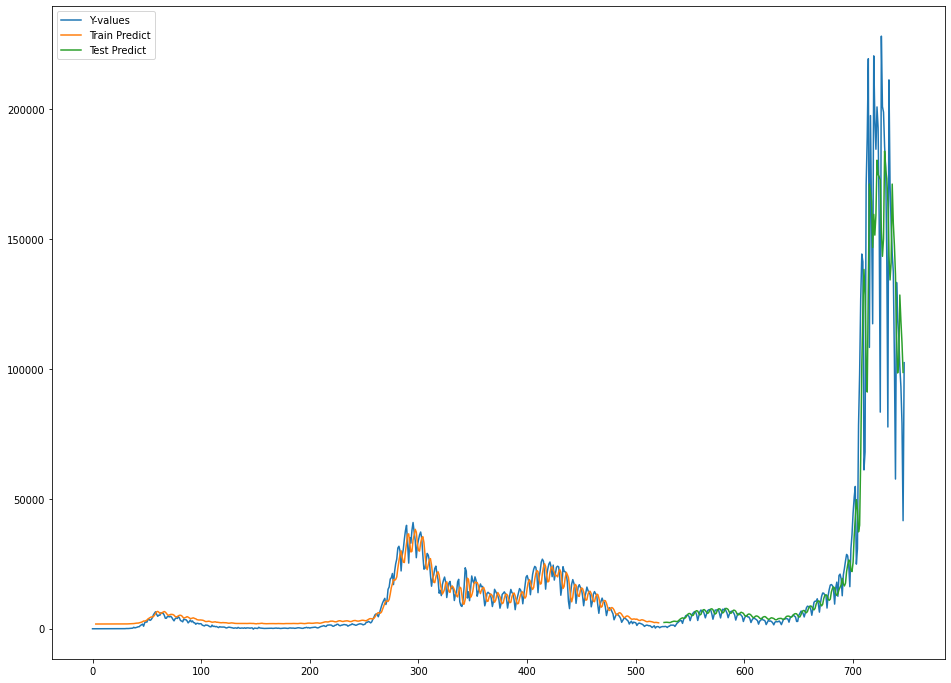

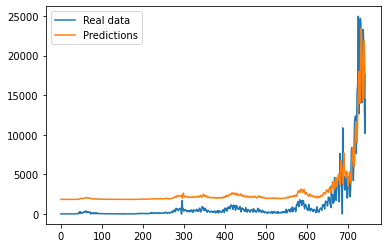

In [109]:
timesteps = 3
no_days = 365
X_train, y_train_scaled, X_test, y_test_scaled, scaler, df1, y_train, y_test, test_data = preprocess(df, "Italy", timesteps, "MinMaxScaler")
history, our_model = model("Adam", 0.001, X_train, y_train_scaled, timesteps)
train_prediction = predict(X_train, our_model, scaler)
test_prediction = predict(X_test, our_model, scaler)
rmse_train, rmse_test = RMSE(y_train, y_test, train_prediction, test_prediction) 
plots(df1, scaler, timesteps, train_prediction, test_prediction)
new_days_pred = predict_future(y_test, timesteps, our_model, no_days, scaler)
new_country_test = test_new_data(df, "Norway", scaler, our_model, timesteps)

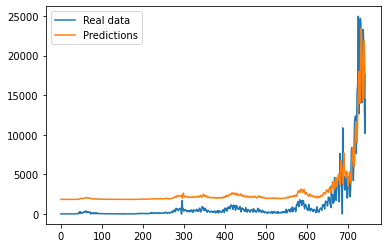

In [110]:
new_country_test = test_new_data(df, "Norway", scaler, our_model, timesteps)

In [61]:
import itertools as it
grid = {"Dropout": [0.1, 0.2, 0.3, 0.4], "Nodes": [20, 30], "Layers": [1], "Scaler": ["MinMaxScaler"], "Timesteps": [12,13,14], "Optimizer": ["Adam"], "Model": ["GRU"]}

allNames = sorted(grid)
all_combinations = it.product(*(grid[Name] for Name in allNames))
the_list = list(all_combinations)
print(len(the_list))

24


In [112]:
for i in range(len(the_list)):
    print(the_list[i][3])


MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
StandardScaler
MinMaxScaler
Standar

In [113]:
print(the_list[2][2])

20


In [52]:
grid1 = {"Dropout": [0.1, 0.2, 0.3, 0.4], "Nodes": [20, 30], "Layers": [1], "Scaler": ["MinMaxScaler"], "Timesteps": [3, 4], "Optimizer": ["Adam"], "Model": ["GRU"]}
allNames = sorted(grid)
all_combinations1 = it.product(*(grid1[Name] for Name in allNames))
the_list1 = list(all_combinations1)
print(len(the_list1))

16


In [2]:
from pathlib import Path
Path.cwd()

WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/Ej till docker')

In [10]:
list(Path.cwd().joinpath("Trained on one country").glob("**/rmse_test.pickle"))

[WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained on one country/Aaron Deluca/rmse_test.pickle'),
 WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained on one country/Aaron Whitaker/rmse_test.pickle'),
 WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained on one country/Adam Brunner/rmse_test.pickle'),
 WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained on one country/Addie Schutt/rmse_test.pickle'),
 WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained on one country/Adele Mordino/rmse_test.pickle'),
 WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained on one country/Afton Rodman/rmse_test.pickle'),
 WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained on one country/Aida Brannan/rmse_test.pickle'),
 WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained on one country/Aida Mcelroy/rmse_test.pickle'),
 WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/ML/Trained o

In [3]:
import pickle
all_rmse_two_country = []
folder_name_two_country = []
for i in (list(Path.cwd().joinpath("Första träningen").glob("**/rmse_test.pickle"))):
    with open((i), "rb") as handle:
        rmse_test = pickle.load(handle)
        all_rmse_two_country.append(rmse_test)
        folder_name_two_country.append(i)
min_value_two_country = min(all_rmse_two_country)

min_index_two_country = all_rmse_two_country.index(min_value_two_country)
print(min_value_two_country, min_index_two_country)
folder_name_two_country[min_index_two_country]

1183.8668791355165 4


WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/Ej till docker/Första träningen/Edgar Johnson/rmse_test.pickle')

In [4]:
import pickle
all_rmse_one_country = []
folder_name_one_country = []
for i in (list(Path.cwd().joinpath("Ger_Den_Net_Swi_Aus").glob("**/rmse_test.pickle"))):
    with open((i), "rb") as handle:
        rmse_test = pickle.load(handle)
        all_rmse_one_country.append(rmse_test)
        folder_name_one_country.append(i)
min_value_one_country = min(all_rmse_one_country)

min_index_one_country = all_rmse_one_country.index(min_value_one_country)
print(min_value_one_country, min_index_one_country)
folder_name_one_country[min_index_one_country]

1187.0608233829166 22


WindowsPath('c:/Users/tobia/OneDrive/Skrivbord/ML_INTRO/Ej till docker/Ger_Den_Net_Swi_Aus/Yoko Beckham/rmse_test.pickle')

In [65]:
all_rmse = []
folder_name = []
for i in (list(Path.cwd().joinpath("Första Träningen").glob("Jess Armstrong/dictionary.pickle"))):
    with open((i), "rb") as handle:
        dictionary_ = pickle.load(handle)
        print(dictionary_)
        print(i)

(0.2, 1, 'GRU', 30, 'Adam', 'MinMaxScaler', 13)
c:\Users\tobia\OneDrive\Skrivbord\ML_INTRO\ML\Första Träningen\Jess Armstrong\dictionary.pickle


In [66]:
all_rmse = []
folder_name = []
for i in (list(Path.cwd().joinpath("Första Träningen").glob("Karl Smith/dictionary.pickle"))):
    with open((i), "rb") as handle:
        dictionary_ = pickle.load(handle)
        print(dictionary_)
        print(i)

(0.1, 1, 'GRU', 20, 'Adam', 'MinMaxScaler', 14)
c:\Users\tobia\OneDrive\Skrivbord\ML_INTRO\ML\Första Träningen\Karl Smith\dictionary.pickle


In [59]:
df_country_cases = df[["Country/Region", "Sweden"]].copy()
df_country_cases = df_country_cases.drop(labels=0, axis=0)
df_country_cases.columns=["Date", "Confirmed Cases"]
df_country_cases["Date"] = pd.to_datetime(df_country_cases["Date"], format="%m/%d/%y")
df1 = df_country_cases["Confirmed Cases"].to_numpy()


In [60]:
print(df1)

[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 1.00000e+00
 8.00000e+00 3.00000e+00 0.00000e+00 5.00000e+00 1.30000e+01 3.00000e+01
 2.50000e+01 5.90000e+01 3.30000e+01 4.60000e+01 1.01000e+02 9.80000e+01
 1.96000e+02 1.51000e+02 1.52000e+02 7.10000e+01 6.90000e+01 8.30000e+01
 1.19000e+02 1.45000e+02 1.43000e+02 1.80000e+02 1.35000e+02 1.18000e+02
 1.82000e+02 2.30000e+02 3.14000e+02 2.86000e+02 3.65000e+02 3.00000e+02
 2.80000e+02 4.16000e+02 4.75000e+02 4.86000e+02 5.54000e+02 6.01000e+02
 3.57000e+02 3.40000e+02 3.89000e+02 7.38000e+02 6.55000e+02 6.45000e+02
 4.54000e+02 3.95000e+02 4.64000e+02 4.37000e+02 4.

### TsFresh

In [5]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute, make_forecasting_frame
from tsfresh.feature_extraction import ComprehensiveFCParameters, settings

In [6]:
df = pd.read_csv("Convenient_global_confirmed_cases.csv")

In [10]:
df_country_cases = df[["Country/Region", "Norway"]].copy()
df_country_cases = df_country_cases.drop(labels=0, axis=0)
df_country_cases.columns=["Date", "Confirmed Cases"]
df_country_cases["Date"] = pd.to_datetime(df_country_cases["Date"], format="%m/%d/%y")

In [18]:
df_country_cases.index = df_country_cases.Date

In [19]:
df_shift, y_air = make_forecasting_frame(df_country_cases["Confirmed Cases"], kind="Cases", max_timeshift=12, rolling_direction=1)
print(df_shift)

Rolling: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


                             id       time    value   kind
1     (id, 2020-01-24 00:00:00) 2020-01-23      0.0  Cases
3     (id, 2020-01-25 00:00:00) 2020-01-23      0.0  Cases
4     (id, 2020-01-25 00:00:00) 2020-01-24      0.0  Cases
6     (id, 2020-01-26 00:00:00) 2020-01-23      0.0  Cases
7     (id, 2020-01-26 00:00:00) 2020-01-24      0.0  Cases
...                         ...        ...      ...    ...
9640  (id, 2022-02-08 00:00:00) 2022-02-03  21804.0  Cases
9641  (id, 2022-02-08 00:00:00) 2022-02-04  20856.0  Cases
9642  (id, 2022-02-08 00:00:00) 2022-02-05  13143.0  Cases
9643  (id, 2022-02-08 00:00:00) 2022-02-06  10172.0  Cases
9644  (id, 2022-02-08 00:00:00) 2022-02-07  17652.0  Cases

[8898 rows x 4 columns]


In [20]:
df_shift

,id,time,value,kind
1,"(id, 2020-01-24 00:00:00)",2020-01-23,0.0,Cases
3,"(id, 2020-01-25 00:00:00)",2020-01-23,0.0,Cases
4,"(id, 2020-01-25 00:00:00)",2020-01-24,0.0,Cases
6,"(id, 2020-01-26 00:00:00)",2020-01-23,0.0,Cases
7,"(id, 2020-01-26 00:00:00)",2020-01-24,0.0,Cases
...,...,...,...,...
9640,"(id, 2022-02-08 00:00:00)",2022-02-03,21804.0,Cases
9641,"(id, 2022-02-08 00:00:00)",2022-02-04,20856.0,Cases
9642,"(id, 2022-02-08 00:00:00)",2022-02-05,13143.0,Cases
9643,"(id, 2022-02-08 00:00:00)",2022-02-06,10172.0,Cases


In [21]:
extraction_settings = ComprehensiveFCParameters()
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False, default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


In [22]:
X

value__variance_larger_than_standard_deviation  \
id 2020-01-24                                             0.0   
   2020-01-25                                             0.0   
   2020-01-26                                             0.0   
   2020-01-27                                             0.0   
   2020-01-28                                             0.0   
...                                                       ...   
   2022-02-04                                             1.0   
   2022-02-05                                             1.0   
   2022-02-06                                             1.0   
   2022-02-07                                             1.0   
   2022-02-08                                             1.0   

               value__has_duplicate_max  value__has_duplicate_min  \
id 2020-01-24                       0.0                       0.0   
   2020-01-25                       1.0                       1.0   
   2020-01-26                       1.0                       1.0   
   2020-01-27                       1.0                       1.0   
   2020-01-28                       1.0                       1.0   
...                                 ...                       ...   
   2022-02-04                       0.0                       0.0   
   2022-02-05                       0.0                       0.0   
   2022-02-06                       0.0                       0.0   
   2022-02-07                       0.0                       0.0   
   2022-02-08                       0.0                       0.0   

               value__has_duplicate  value__sum_values  value__abs_energy  \
id 2020-01-24                   0.0                0.0       0.000000e+00   
   2020-01-25                   1.0                0.0       0.000000e+00   
   2020-01-26                   1.0                0.0       0.000000e+00   
   2020-01-27                   1.0                0.0       0.000000e+00   
   2020-01-28                   1.0                0.0       0.000000e+00   
...                             ...                ...                ...   
   2022-02-04                   0.0           239439.0       4.997486e+09   
   2022-02-05                   0.0           247649.0       5.272538e+09   
   2022-02-06                   0.0           242250.0       5.101470e+09   
   2022-02-07                   0.0           227993.0       4.608164e+09   
   2022-02-08                   0.0           220968.0       4.310803e+09   

               value__mean_abs_change  value__mean_change  \
id 2020-01-24               86.409091            0.272727   
   2020-01-25                0.000000            0.000000   
   2020-01-26                0.000000            0.000000   
   2020-01-27                0.000000            0.000000   
   2020-01-28                0.000000            0.000000   
...                               ...                 ...   
   2022-02-04             3038.363636          832.545455   
   2022-02-05             2588.545455          210.363636   
   2022-02-06             2754.545455        -1026.000000   
   2022-02-07             3002.090909        -1318.636364   
   2022-02-08             3646.727273         -603.272727   

               value__mean_second_derivative_central  value__median  ...  \
id 2020-01-24                                   0.00            0.0  ...   
   2020-01-25                                   0.00            0.0  ...   
   2020-01-26                                   0.00            0.0  ...   
   2020-01-27                                   0.00            0.0  ...   
   2020-01-28                                   0.00            0.0  ...   
...                                              ...            ...  ...   
   2022-02-04                                -369.55        21661.5  ...   
   2022-02-05                                -341.75        21661.5  ...   
   2022-02-06                                -398.05        216

In [34]:
from autots import AutoTS

In [35]:
df = pd.read_csv("Convenient_global_confirmed_cases.csv")

In [41]:
df_norway_cases = df[["Country/Region", "Norway"]].copy()
df_norway_cases = df_norway_cases.drop(labels=0, axis=0)
df_norway_cases.columns=["Date", "Confirmed Cases"]
df_norway_cases["Date"] = pd.to_datetime(df_norway_cases["Date"], format="%m/%d/%y")

In [42]:
df_norway_cases

,Date,Confirmed Cases
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
5,2020-01-27,0.0
...,...,...
744,2022-02-04,20856.0
745,2022-02-05,13143.0
746,2022-02-06,10172.0
747,2022-02-07,17652.0


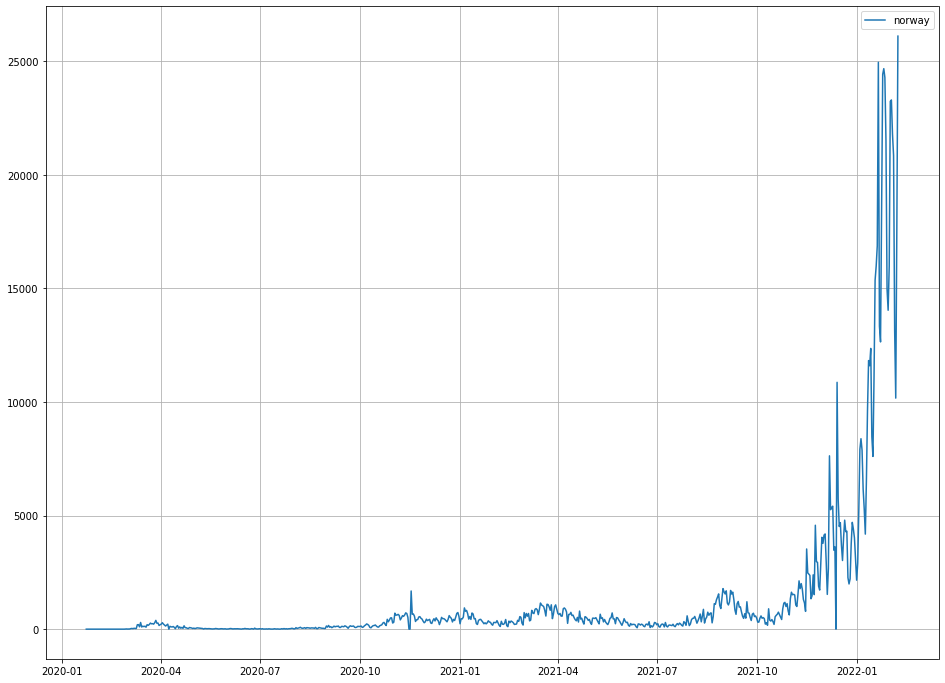

In [64]:
plt.figure(figsize=(16,12))
plt.plot(df_norway_cases["Date"], df_norway_cases["Confirmed Cases"], label="norway")

plt
plt.legend()
plt.grid()
plt.show()

In [58]:
df_norway_cases

,Date,Confirmed Cases
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
5,2020-01-27,0.0
...,...,...
744,2022-02-04,20856.0
745,2022-02-05,13143.0
746,2022-02-06,10172.0
747,2022-02-07,17652.0


In [ ]:
model = AutoTS(forecast_length=22, frequency="infer", ensemble="simple", drop_data_older_than_periods=100)
model = model.fit(df_norway_cases, date_col="Date", value_col="Confirmed Cases", id_col=None)

In [55]:
prediction = model.predict()
forecast = prediction.forecast
print(forecast)

            Confirmed Cases
2022-02-09     25596.439031
2022-02-10     24347.878057
2022-02-11     23646.317084
2022-02-12     16179.756111
2022-02-13     13455.195138
2022-02-14     21181.634165
2022-02-15     29885.073192
2022-02-16     27321.512218
2022-02-17     26072.951245
2022-02-18     25371.390272
2022-02-19     17904.829299
2022-02-20     15180.268326
2022-02-21     22906.707353
2022-02-22     31610.146379
2022-02-23     29046.585406
2022-02-24     27798.024433
2022-02-25     27096.463460
2022-02-26     19629.902487
2022-02-27     16905.341514
2022-02-28     24631.780540
2022-03-01     33335.219567
2022-03-02     30771.658594


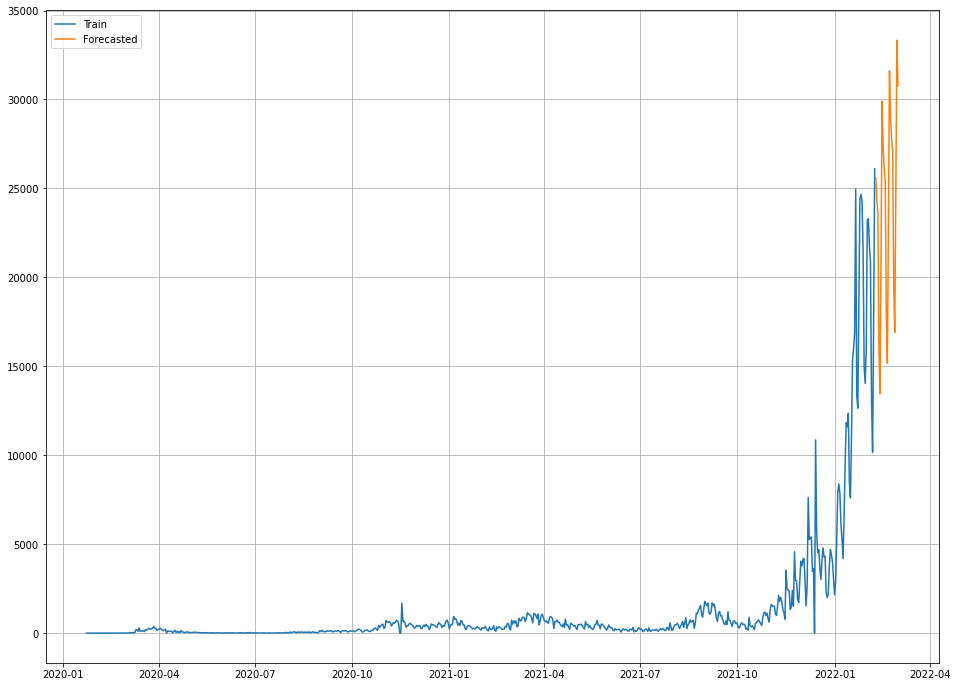

In [68]:
plt.figure(figsize=(16,12))
plt.plot(df_norway_cases["Date"], df_norway_cases["Confirmed Cases"], label="Train")
plt.plot(forecast["Confirmed Cases"], label="Forecasted")
plt.legend()
plt.grid()
plt.show()